## Step 0. 
Make a sample classification dataset:

In [1]:
# import requires libraries
import warnings
warnings.filterwarnings("ignore", category=Warning)

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from SKSurrogate import *
# make up a classification dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=6, n_redundant=2)
Xy = np.hstack((X, np.reshape(y, (-1, 1))))
# make up some names for columns of the data
cols = ['cl%d'%(_+1) for _ in range(10)] + ['target']
# turn it into a pandas DataFrame
df = np2df(Xy, cols)()

## Step 1. 
Initiate the tracker and register the data:

In [2]:
# initialize the tracker with a task called 'sample'
MLTr = mltrack('sample', db_name="sample.db")
# register the data
MLTr.RegisterData(df, 'target')
# modify the description of the task
MLTr.UpdateTask({'description': "This is a sample task to demonstrate capabilities of the mltrace."})

## Step 2. 
Get to know the data by visualizing correlations and sensitivities:

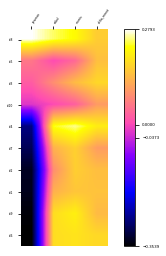

In [3]:
from sklearn.gaussian_process.kernels import Matern, Sum, ExpSineSquared
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore", category=Warning)

# use a regressor to approximate the data
param_grid_kr = {"alpha": np.logspace(-4, 1, 20),
              "kernel": [Sum(Matern(), ExpSineSquared(l, p))
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
rgs = RandomizedSearchCV(KernelRidge(),
        param_distributions=param_grid_kr, n_iter=10, cv=2)
# ask for specific weights to be calculated and recorded
MLTr.FeatureWeights(regressor=rgs,
        weights=('pearson', 'sobol', 'morris', 'delta-mmnt'))
# visualise
plt1 = MLTr.heatmap(sort_by='pearson')
#plt1.show()

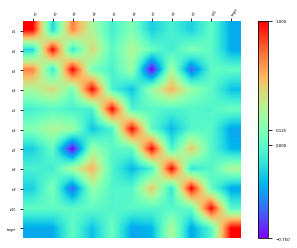

In [4]:
cor = df.corr()
plt2 = p = MLTr.heatmap(cor, idx_col=None, cmap='rainbow')

## Step 3. 
Examine and log a random forest model and its metrics:

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit
# retrieve data
X, y = MLTr.get_data()
# init classifier
clf = RandomForestClassifier(n_estimators=50)
# log the classifier
clf = MLTr.LogModel(clf, "RandomForestClassifier(50)")
# find the average metrics
print(MLTr.LogMetrics(clf, cv=ShuffleSplit(5, .25)))

{'accuracy': 0.9168000000000001, 'auc': 0.9781085630410509, 'precision': 0.9342421726001271, 'f1': 0.9183404537120119, 'recall': 0.9038833038152218, 'mcc': 0.8348771709836751, 'logloss': 2.8736524228522797, 'variance': None, 'max_error': None, 'mse': None, 'mae': None, 'r2': None}


## Step 4. 
Search for best classifier in terms of accuracy

In [6]:
from SKSurrogate import *
# set up the confic dictionary
config = {
    # estimators
    'sklearn.naive_bayes.GaussianNB': {
        'var_smoothing': Real(1.e-9, 2.e-1)
    },
    'sklearn.linear_model.LogisticRegression': {
        'penalty': Categorical(["l1", "l2"]),
        'C': Real(1.e-6, 10.),
        "class_weight": HDReal((1.e-5, 1.e-5), (20., 20.))
    },
    "lightgbm.LGBMClassifier": {
        "boosting_type": Categorical(['gbdt', 'dart', 'goss', 'rf']),
        "num_leaves": Integer(2, 100),
        "learning_rate": Real(1.e-7, 1. - 1.e-6),  # prior='uniform'),
        "n_estimators": Integer(5, 250),
        "min_split_gain": Real(0., 1.),  # prior='uniform'),
        "subsample": Real(1.e-6, 1.),  # prior='uniform'),
        "importance_type": Categorical(['split', 'gain'])
    },
    # preprocessing
    'sklearn.preprocessing.StandardScaler': {
        'with_mean': Categorical([True, False]),
        'with_std': Categorical([True, False]),
    },
    'sklearn.preprocessing.Normalizer': {
        'norm': Categorical(['l1', 'l2', 'max'])
    },
}
# initiate and perform the search
A = AML(config=config, length=3, check_point='./', verbose=1)
A.eoa_fit(X, y, max_generation=10, num_parents=10)
# retrieve and log the best
eoa_clf = A.best_estimator_
eoa_clf = MLTr.LogModel(eoa_clf, "Best of EOA Surrogate Search")
print(MLTr.LogMetrics(eoa_clf, cv=ShuffleSplit(5, .25)))
MLTr.PreserveModel(eoa_clf)

('lightgbm.LGBMClassifier', 'sklearn.linear_model.LogisticRegression', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.933333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LGBMClassifier(boosting_type='gbdt',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='split',
                                                            learning_rate=0.3699748050190903,
                                                            max_depth=-1,
                                                            min_child_samples=20,
                                                            min_child_weight=0.001,
                            

('sklearn.linear_model.LogisticRegression', 'sklearn.preprocessing.StandardScaler', 'sklearn.linear_model.LogisticRegression')
------------------------------------------------------------------------------------------
score:-0.868000
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=7.858403513425746,
                                                                class_weight={0.0: 0.9188676099132286,
                                                                              1.0: 17.761300634779992},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                                    

         verbose=False)
('sklearn.linear_model.LogisticRegression', 'sklearn.preprocessing.Normalizer', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.877333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=9.851050115950628,
                                                                class_weight={0.0: 8.316159030109725,
                                                                              1.0: 15.17073991141589},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                           

         verbose=False)
('sklearn.preprocessing.Normalizer', 'sklearn.linear_model.LogisticRegression', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.865333
Pipeline(memory=None,
         steps=[('stp_0', Normalizer(copy=True, norm='l2')),
                ('stp_1',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=4.97334652173702,
                                                                class_weight={0.0: 11.054231332798418,
                                                                              1.0: 8.833248062860056},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                             

         verbose=False)
('sklearn.linear_model.LogisticRegression', 'sklearn.naive_bayes.GaussianNB', 'sklearn.linear_model.LogisticRegression')
------------------------------------------------------------------------------------------
score:-0.885333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=7.045727850583113,
                                                                class_weight={0.0: 7.852269256195544,
                                                                              1.0: 5.044531640396322},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                    

         verbose=False)
('sklearn.preprocessing.Normalizer', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.881333
Pipeline(memory=None,
         steps=[('stp_0', Normalizer(copy=True, norm='l2')),
                ('stp_1', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)
('sklearn.naive_bayes.GaussianNB', 'lightgbm.LGBMClassifier')
------------------------------------------------------------------------------------------
score:-0.922667
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=GaussianNB(priors=None,
                                                        var_smoothing=0.11337654491049926),
                                   probs=True, res=True)),
                ('stp_1',
                 LGBMClassifier(boosting_type='dart', class_weight=None,
                               

         verbose=False)
('sklearn.linear_model.LogisticRegression', 'sklearn.preprocessing.Normalizer', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.877333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=9.851050115950628,
                                                                class_weight={0.0: 8.316159030109725,
                                                                              1.0: 15.17073991141589},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                           

------------------------------------------------------------------------------------------
score:-0.877333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=9.851050115950628,
                                                                class_weight={0.0: 8.316159030109725,
                                                                              1.0: 15.17073991141589},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                                                max_iter=100,
                                                                multi_class='warn',
                   

         verbose=False)
('sklearn.linear_model.LogisticRegression', 'sklearn.preprocessing.Normalizer', 'lightgbm.LGBMClassifier')
------------------------------------------------------------------------------------------
score:-0.941333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=8.870057358830348,
                                                                class_weight={0.0: 1.791724480361179,
                                                                              1.0: 19.09226216240248},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                                  

         verbose=False)
('lightgbm.LGBMClassifier', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.928000
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LGBMClassifier(boosting_type='dart',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='gain',
                                                            learning_rate=0.999999,
                                                            max_depth=-1,
                                                            min_child_samples=20,
                                                            min_child_weight=0.001,
                                                          

         verbose=False)
('lightgbm.LGBMClassifier', 'sklearn.linear_model.LogisticRegression', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.933333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LGBMClassifier(boosting_type='gbdt',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='split',
                                                            learning_rate=0.3699748050190903,
                                                            max_depth=-1,
                                                            min_child_samples=20,
                                                            min_child_weight=0.001,
    

         verbose=False)
('sklearn.naive_bayes.GaussianNB', 'sklearn.preprocessing.Normalizer', 'lightgbm.LGBMClassifier')
------------------------------------------------------------------------------------------
score:-0.942667
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=GaussianNB(priors=None,
                                                        var_smoothing=1e-09),
                                   probs=True, res=True)),
                ('stp_1', Normalizer(copy=True, norm='l1')),
                ('stp_2',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.999999, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=134, n_jobs=-1,

         verbose=False)
('sklearn.naive_bayes.GaussianNB', 'sklearn.preprocessing.Normalizer', 'lightgbm.LGBMClassifier')
------------------------------------------------------------------------------------------
score:-0.942667
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=GaussianNB(priors=None,
                                                        var_smoothing=1e-09),
                                   probs=True, res=True)),
                ('stp_1', Normalizer(copy=True, norm='l1')),
                ('stp_2',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.999999, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=134, n_jobs=-1,

         verbose=False)
('sklearn.linear_model.LogisticRegression', 'sklearn.preprocessing.Normalizer', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.877333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=9.851050115950628,
                                                                class_weight={0.0: 8.316159030109725,
                                                                              1.0: 15.17073991141589},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                           

         verbose=False)
('lightgbm.LGBMClassifier', 'sklearn.linear_model.LogisticRegression', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.933333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LGBMClassifier(boosting_type='gbdt',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='split',
                                                            learning_rate=0.3699748050190903,
                                                            max_depth=-1,
                                                            min_child_samples=20,
                                                            min_child_weight=0.001,
    

         verbose=False)
('sklearn.linear_model.LogisticRegression', 'sklearn.preprocessing.Normalizer', 'lightgbm.LGBMClassifier')
------------------------------------------------------------------------------------------
score:-0.941333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=8.870057358830348,
                                                                class_weight={0.0: 1.791724480361179,
                                                                              1.0: 19.09226216240248},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                                  

         verbose=False)
('sklearn.naive_bayes.GaussianNB', 'lightgbm.LGBMClassifier', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.933333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=GaussianNB(priors=None,
                                                        var_smoothing=0.01585862517754542),
                                   probs=True, res=True)),
                ('stp_1',
                 StackingEstimator(decision=True,
                                   estimator=LGBMClassifier(boosting_type='gbdt',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='gain',
                                                    

         verbose=False)
('lightgbm.LGBMClassifier', 'sklearn.linear_model.LogisticRegression', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.933333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LGBMClassifier(boosting_type='gbdt',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='split',
                                                            learning_rate=0.3699748050190903,
                                                            max_depth=-1,
                                                            min_child_samples=20,
                                                            min_child_weight=0.001,
    

         verbose=False)
('sklearn.linear_model.LogisticRegression', 'sklearn.preprocessing.Normalizer', 'lightgbm.LGBMClassifier')
------------------------------------------------------------------------------------------
score:-0.941333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=8.870057358830348,
                                                                class_weight={0.0: 1.791724480361179,
                                                                              1.0: 19.09226216240248},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                                  

         verbose=False)
('sklearn.naive_bayes.GaussianNB', 'lightgbm.LGBMClassifier', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.933333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=GaussianNB(priors=None,
                                                        var_smoothing=0.01585862517754542),
                                   probs=True, res=True)),
                ('stp_1',
                 StackingEstimator(decision=True,
                                   estimator=LGBMClassifier(boosting_type='gbdt',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='gain',
                                                    

         verbose=False)
('sklearn.preprocessing.StandardScaler', 'sklearn.linear_model.LogisticRegression', 'lightgbm.LGBMClassifier')
------------------------------------------------------------------------------------------
score:-0.937333
Pipeline(memory=None,
         steps=[('stp_0',
                 StandardScaler(copy=True, with_mean=True, with_std=False)),
                ('stp_1',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=10.0,
                                                                class_weight={0.0: 20.0,
                                                                              1.0: 20.0},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                             

         verbose=False)
('sklearn.linear_model.LogisticRegression', 'sklearn.preprocessing.Normalizer', 'sklearn.naive_bayes.GaussianNB')
------------------------------------------------------------------------------------------
score:-0.877333
Pipeline(memory=None,
         steps=[('stp_0',
                 StackingEstimator(decision=True,
                                   estimator=LogisticRegression(C=9.851050115950628,
                                                                class_weight={0.0: 8.316159030109725,
                                                                              1.0: 15.17073991141589},
                                                                dual=False,
                                                                fit_intercept=True,
                                                                intercept_scaling=1,
                                                                l1_ratio=None,
                                           

## Step 5. 
Plot learning curves

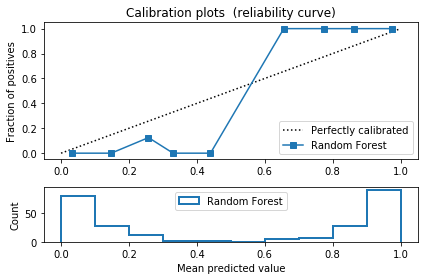

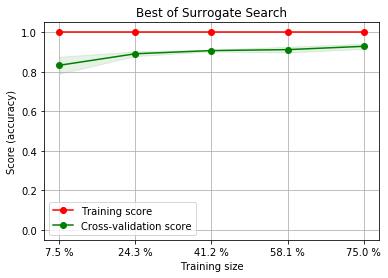

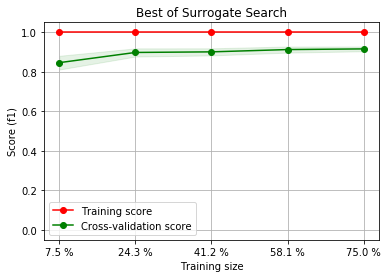

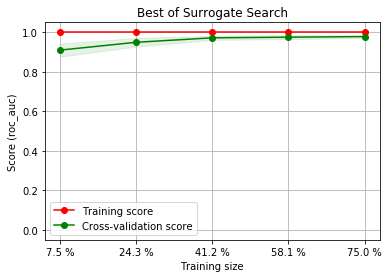

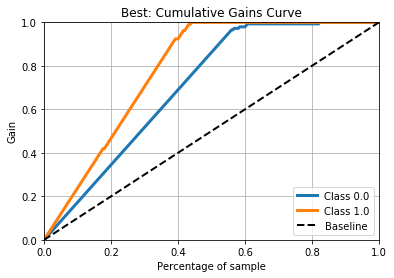

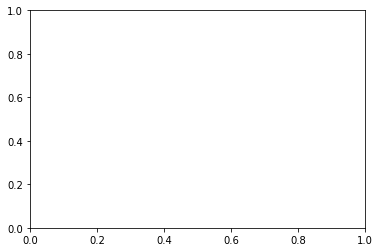

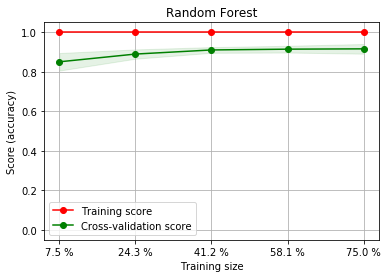

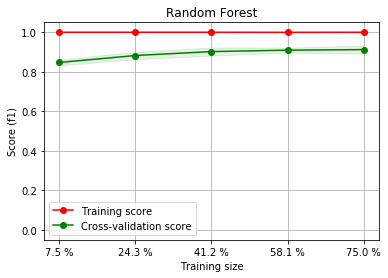

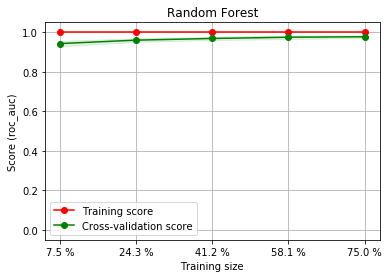

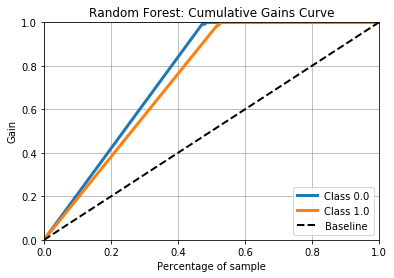

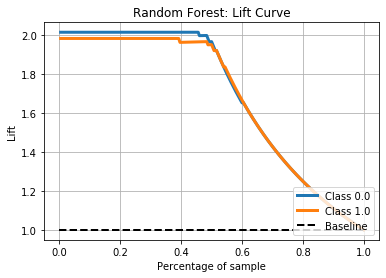

In [7]:
# the best of EOA Surrogate Search
MLTr.plot_learning_curve(eoa_clf, "Best of Surrogate Search", cv=ShuffleSplit(5, .25), measure='accuracy')
MLTr.plot_learning_curve(eoa_clf, "Best of Surrogate Search", cv=ShuffleSplit(5, .25), measure='f1')
MLTr.plot_learning_curve(eoa_clf, "Best of Surrogate Search", cv=ShuffleSplit(5, .25), measure='roc_auc')
MLTr.plot_calibration_curve(eoa_clf, "Best of Surrogate Search")
MLTr.plot_cumulative_gain(eoa_clf, title="Best: Cumulative Gains Curve")
MLTr.plot_lift_curve(eoa_clf, title="Best: Lift Curve")
# Random Forest
MLTr.plot_learning_curve(clf, "Random Forest", cv=ShuffleSplit(5, .25), measure='accuracy')
MLTr.plot_learning_curve(clf, "Random Forest", cv=ShuffleSplit(5, .25), measure='f1')
MLTr.plot_learning_curve(clf, "Random Forest", cv=ShuffleSplit(5, .25), measure='roc_auc')
MLTr.plot_calibration_curve(clf, "Random Forest")
MLTr.plot_cumulative_gain(clf, title="Random Forest: Cumulative Gains Curve")
MLTr.plot_lift_curve(clf, title="Random Forest: Lift Curve")